## Annotate volume as heatmap

- annotation of measurement volume for young (P08) and old (P20)
- function from `pyclesperanto_prototype` will be used
    - `cle.replace_intensities` replaces the intensity of the image with a measurement of choice

In [1]:
import apoc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyclesperanto_prototype as cle

from napari_simpleitk_image_processing import label_statistics

import sys
sys.path.append("../../../../../../01_python_definitions")
from fluorescent_microscopy_analysis import predict_image, rescale_image, scale_bar_image, heatmap_image

### Load pixel classifier

In [2]:
quapos_lm = apoc.ObjectSegmenter(opencl_filename="../../01-training-and-validation/2023-07-08-kaspr-version-3.cl")
quapos_lm.feature_importances()

{'gaussian_blur=1': 0.32557488170342097,
 'difference_of_gaussian=1': 0.4231073391932076,
 'laplace_box_of_gaussian_blur=1': 0.25131777910337144}

### Create a file list with the corresponding images

In [3]:
#define file_path with images
file_path = "C:/Users/fsalo/Documents/studium/02-master_reg_bio/ag-ader-master-thesis/paper-quantification-of-os/figures/results/figure-2-result-classifier/images-microscopy/lm/"

save_path = "../../plots-images/quapos-paper/sup-fig-3-images/"

In [4]:
#define a filelist accordingly
file_list = os.listdir(file_path)
file_list

['C1-p08-20x-zoom-3.5-replicate-3.tif',
 'C1-p12-20x-zoom-flo-2.6-replicate-9.tif',
 'C1-p16-20x-zoom-suse-1.5-replicate-19.tif',
 'C1-p20-20x-zoom-flo-1.4-replicate-21.tif',
 'C1-p24-20x-zoom-1.6-replicate-25.tif']

### Show prediction for early and late stage

- the corresponding images from figure 2 will be loaded and predicted

#### Load the image

In [5]:
image_p08 = cle.imread(file_path + file_list[0])
image_p20 = cle.imread(file_path + file_list[3])

#### Predict the image

In [6]:
prediction_p08 = predict_image(image=image_p08, classifier=quapos_lm)
prediction_p20 = predict_image(image=image_p20, classifier=quapos_lm)

#### Rescale the image

In [11]:
image_p08 = rescale_image(image=image_p08, voxel_x=0.323, voxel_y=0.323, voxel_z=0.490)
image_p20 = rescale_image(image=image_p20, voxel_x=0.323, voxel_y=0.323, voxel_z=0.490)

#### Rescale the prediction

In [7]:
prediction_p08 = rescale_image(image=prediction_p08, voxel_x=0.323, voxel_y=0.323, voxel_z=0.490)
prediction_p20 = rescale_image(image=prediction_p20, voxel_x=0.323, voxel_y=0.323, voxel_z=0.490)

#### Compute a scale bar

In [8]:
scale_bar, cmap = scale_bar_image(image=image_p08[15, 0:200, 600:800],
                                  micron_length=0.323,
                                  scale_length=25)

3 3 lens
3 3 lens


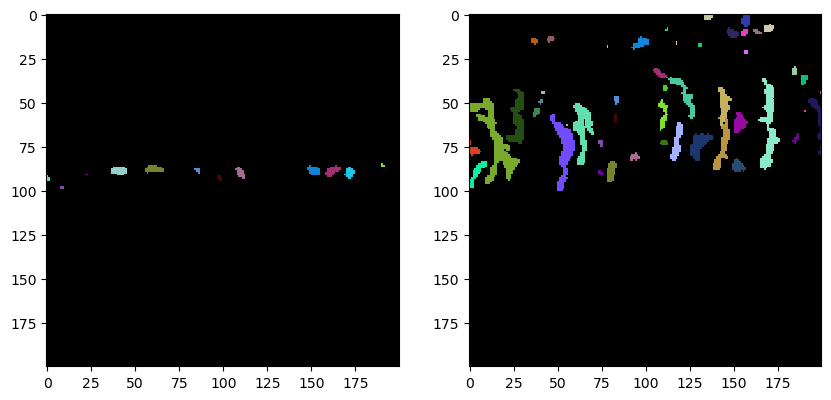

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

cle.imshow(prediction_p08[..., 0:200, 600:800], plot=axs[0], labels=True)
cle.imshow(prediction_p20[..., 90:290, 200:400], plot=axs[1], labels=True)

### Annotation of the volume

- custom function `heatmap_annotation` requires 3 arguments:
    - a segmentation results
    - a dataframe with measurements
    - a feature for the annotation
    
- here the volume will be annotated with the function: `label_statistics` from `napari_simpleitk_image_processing`

### Compute volume map for P08

In [13]:
statistics_p08 = label_statistics(intensity_image=image_p08,
                                  label_image=prediction_p08,
                                  size=True,
                                  intensity=True)
statistics_p08["volume"] = statistics_p08["number_of_pixels"] * np.power(0.323, 3)
volume_map_p08 = heatmap_image(segmentation=prediction_p08,
                                    dataframe=statistics_p08,
                                    feature="volume")

### Compute volume map for P24

In [14]:
statistics_p20 = label_statistics(intensity_image=image_p20,
                                  label_image=prediction_p20,
                                  size=True,
                                  intensity=True)
statistics_p20["volume"] = statistics_p20["number_of_pixels"] * np.power(0.323, 3)
volume_map_p20 = heatmap_image(segmentation=prediction_p20,
                                    dataframe=statistics_p20,
                                    feature="volume")

### Show volume maps next to each other

3 3 lens
3 3 lens


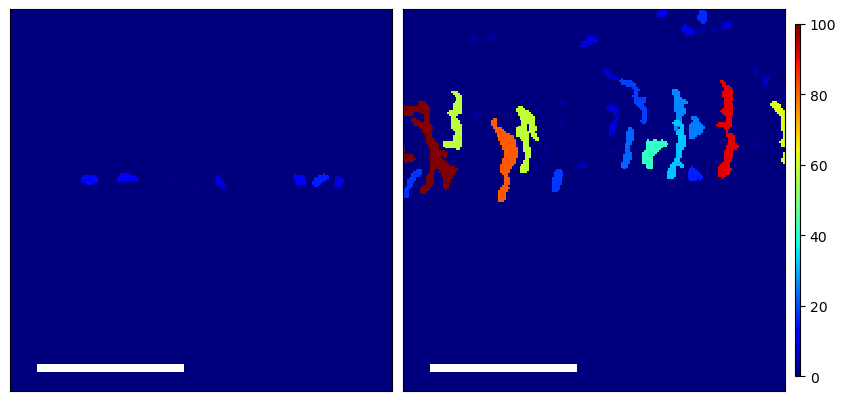

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

cle.imshow(volume_map_p08[..., 0:200, 600:800], 
           plot=axs[0], 
           colormap="jet",
           max_display_intensity=100)
cle.imshow(scale_bar,
           plot=axs[0],
           colormap=cmap)
axs[0].tick_params(left = False,
                right = False,
                labelleft = False,
                labelbottom = False, 
                bottom = False)

cle.imshow(volume_map_p20[..., 90:290, 200:400], 
           plot=axs[1], 
           colormap="jet", 
           colorbar=True,
           max_display_intensity=100)
cle.imshow(scale_bar,
           plot=axs[1],
           colormap=cmap)
axs[1].tick_params(left = False,
                right = False,
                labelleft = False,
                labelbottom = False, 
                bottom = False)

plt.subplots_adjust(wspace=0.03)

plt.savefig(save_path + "01-volume-map.png",
            dpi=300,
            bbox_inches="tight")